Credit: https://github.com/nickypie

# Connect Intensive - Machine Learning Nanodegree
# Lesson 05: Classification with Support Vector Machines

## Objectives
  - Explore more about the plotting capabilities of [`matplotlib.pyplot`](http://matplotlib.org/api/pyplot_api.html)
    - Make [boxplots](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.boxplot) to visualize the median, interquartile range (IQR), and see whether a feature may have outliers (fliers).
    - Make [scatterplots](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) to visualize data in two dimensions.
  - Understand [the different kernels](http://scikit-learn.org/stable/modules/svm.html#kernel-functions) available for [Support Vector Machines (SVMs) in `sklearn`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
  - Learn the difference between hard-margin and soft-margin SVMs
  - Visualize decision boundaries resulting from different kernels
  - Build intuition for hyperparamters, such as `C`, `gamma`, `degree`, *etc.*
  - Review [the `GridSearchCV` method](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with an example using SVMs.
  
## Prerequisites
  - You should have the following python packages installed:
    - [matplotlib](http://matplotlib.org/index.html)
    - [numpy](http://www.scipy.org/scipylib/download.html)
    - [pandas](http://pandas.pydata.org/getpandas.html)
    - [sklearn](http://scikit-learn.org/stable/install.html)

## Getting Started
As usual, we start by importing some useful libraries and modules. Don't worry if you get a warning message when importing `matplotlib` -- it just needs to build the font cache, and the warning is just to alert you that this may take a while the first time the cell is run.

**Run** the cell below to import useful libraries for this notebook.

In [1]:
%matplotlib inline
try:
    import numpy as np
    print("Successfully imported numpy! (Version {})".format(np.version.version))
except ImportError:
    print("Could not import numpy!")

    
try:
    import matplotlib
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    print("Successfully imported matplotlib.pyplot! (Version {})".format(matplotlib.__version__))
except ImportError:
    print("Could not import matplotlib.pyplot!")

    
try:
    import pandas as pd
    print("Successfully imported pandas! (Version {})".format(pd.__version__))
    pd.options.display.max_rows = 10
except ImportError:
    print("Could not import pandas!")

    
try:
    from IPython.display import display
    print("Successfully imported display from IPython.display!")
except ImportError:
    print("Could not import display from IPython.display")
    
try:
    import sklearn
    print("Successfully imported sklearn! (Version {})".format(sklearn.__version__))
    skversion = int(sklearn.__version__[2:4])
except ImportError:
    print("Could not import sklearn!")

Successfully imported numpy! (Version 1.11.1)
Successfully imported matplotlib.pyplot! (Version 1.5.3)
Successfully imported pandas! (Version 0.18.1)
Successfully imported display from IPython.display!
Successfully imported sklearn! (Version 0.17.1)


## Learning about SVM Kernels with Wheat Kernels!

![Kernels!](http://www.seriouseats.com/images/2014/02/20140203-grains-wheatberries.jpg)

The [UCI Machine Learning Repository (MLR)](https://archive.ics.uci.edu/ml/index.html) has many publicly available datasets with which you can hone your model-building skills. The dataset we'll be playing around with today comes from a [Polish study of wheat kernels](http://riad.pk.edu.pl/~pkowal/publikacje/Charytanowicz_et_al%20A%20Complete%20Gradient%20Clustering%20Algorithm%20for%20Features%20Analysis%20of%20X-ray%20Images.pdf). The [seeds data set](https://archive.ics.uci.edu/ml/datasets/seeds) contains seven features relating to the geometric properties of wheat kernels:
  1. area $A$, units of $mm^2$.
  2. perimeter $P$, units of $mm$.
  3. compactness $C = \dfrac{4*\pi*A}{P^2}$, dimensionless.
  4. length of kernel, units of $mm$.
  5. width of kernel, units of $mm$.
  6. asymmetry coefficient, dimensionless.
  7. length of kernel groove, units of $mm$

The data set contains 210 instances, 70 instances of three different varieties of wheat: Kama, Rosa, and Canadian, denoted as varieties 1, 2, and 3, respectively.

**Run** the cell below to create a `pandas` `DataFrame` object, reading the seeds data in from the UCI MLR url.

A few notes:
  - We're using [the `read_table` method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_table.html) because the online data is not in a comma-separated variable (csv) format.
  - We have to manually set the `names` parameter with a list of variable names.
  - We are setting the parameter `header` to `None` because there are no variable names in the online dataset.
  - We're setting the parameter `delim_whitespace` to `True` because some lines in the seeds data set have multiple tab delimiters between features -- this way, `pandas` knows to use all whitespace as a delimeter.

In [2]:
seed_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
seed_names = ["area", "perimeter", "compactness", "length_kernel", "width_kernel",\
              "asymmetry", "length_groove", "variety"]
seed_df = pd.read_table(seed_url, names=seed_names, header=None, delim_whitespace=True)
display(seed_df)

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry,length_groove,variety
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


Let's look at some of the features to see how they compare across wheat kernel varieties.

**Run** the cell below to plot the average wheat kernel area grouped by variety.

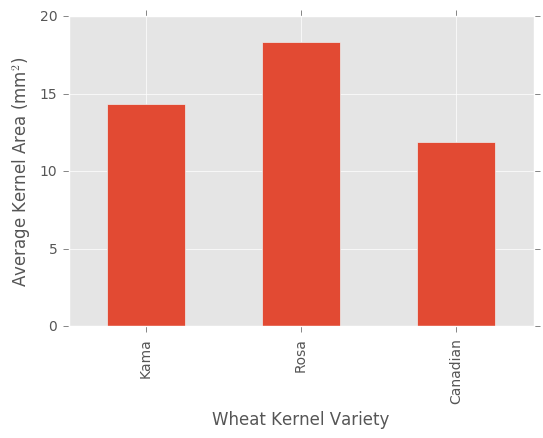

In [3]:
fig = seed_df.groupby("variety").mean()['area'].plot(kind="bar")
x_ticks = plt.xticks(range(3),['Kama', 'Rosa', 'Canadian'])
x_label = plt.xlabel("Wheat Kernel Variety")
y_label = plt.ylabel("Average Kernel Area (mm$^2$)")

It looks like, on average, the Canadian wheat kernels are the smallest in area and the Rosa wheat kernels are the largest, but we can't infer much else from this plot. Do the wheat kernels vary significantly in size? What's the range in areas for each wheat kernel variety? Are there outliers?

## Thinking inside the box(plot)

To answer the above questions, a [**boxplot**](https://en.wikipedia.org/wiki/Box_plot) can help. **Run** the cell below to make a boxplot of the `'area'` of all 210 wheat kernels.

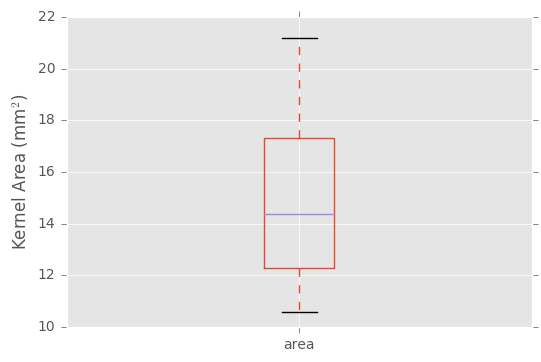

In [4]:
seed_df['area'].plot(kind="box")
y_label = plt.ylabel("Kernel Area (mm$^2$)")

Looking at the resulting plot, there are a few features to note about a boxplot:
  - The purple line just above $14 mm^2$ is the **median** of `seed_df['area']`.
  - The red box that extends from around $12 mm^2$ to about $17 mm^2$ extends from the **lower [quartile](https://en.wikipedia.org/wiki/Quartile)** to the **upper quartile** of `seed_df['area']`. Half of the data lies within this box.
  - The black bars and red dashed lines above and below the box are the **whiskers**. The default setting for pyplot's boxplot is that the whiskers are allowed to extend up to 1.5 times the **[interquartile range (IQR)](https://en.wikipedia.org/wiki/Interquartile_range)**. If the maximum and the minimum values in the dataset are closer to the box than 1.5 times the IQR (as in this example), the caps on the whiskers will extend only to those maximum and minimum values.
    
We'd like to use boxplots to see how different the `'area'` feature is for the three varieties of wheat kernels. To do this, [the `pivot` method](http://pandas.pydata.org/pandas-docs/stable/reshaping.html) in the `pandas` library will help.

**Run** the cell below to display two `DataFrame` objects, to get an idea of what the `pivot` method does:
  1. `seed_df[['area','variety']]`
  2. `seed_df[['area','variety']].pivot(columns='variety', values='area')`

In [5]:
display(seed_df[['area','variety']])
display(seed_df[['area','variety']].pivot(columns='variety', values='area'))

,area,variety
0,15.26,1
1,14.88,1
2,14.29,1
3,13.84,1
4,16.14,1
...,...,...
205,12.19,3
206,11.23,3
207,13.20,3
208,11.84,3


variety,1,2,3
0,15.26,NaN,NaN
1,14.88,NaN,NaN
2,14.29,NaN,NaN
3,13.84,NaN,NaN
4,16.14,NaN,NaN
...,...,...,...
205,NaN,NaN,12.19
206,NaN,NaN,11.23
207,NaN,NaN,13.20
208,NaN,NaN,11.84


We've turned the `'variety'` feature to a column index in the pivot table. The indices are unchanged in our pivot table, but we could change them using the `index` parameter. By default, values that didn't exist have missing values. For example, for the first instance in the `DataFrame`, the `'variety'` feature was equal to 1. Columns 2 and 3 in the pivot table have `NaN` for the first instance.

**Run** the cell below to make boxplots from the pivot table. Does the result seem more descriptive than simply looking at the means of the `'area'` feature for each variety?

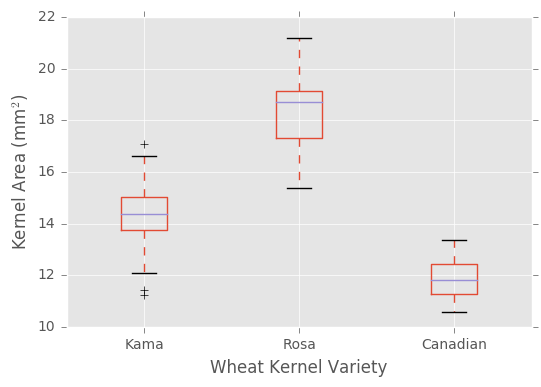

In [6]:
seed_df[['area','variety']].pivot(columns='variety', values='area').plot(kind="box")
x_ticks = plt.xticks(np.arange(1,4),['Kama', 'Rosa', 'Canadian'])
x_label = plt.xlabel("Wheat Kernel Variety")
y_label = plt.ylabel("Kernel Area (mm$^2$)")

Looking at the resulting boxplots, we can see a lot more information about the wheat kernel samples than simply looking at the means. We also see that the Kama variety of wheat kernels has some outliers or fliers beyond the whisker caps, denoted by the `+` symbols.

Personally, I find the default plot settings for boxplots in ggplot2 to be a little drab. **Run** the cell below to generate a boxplot of the same pivot table with different plot settings. Can you follow how the boxplot was customized? Feel free to play with the settings to find a style you like!

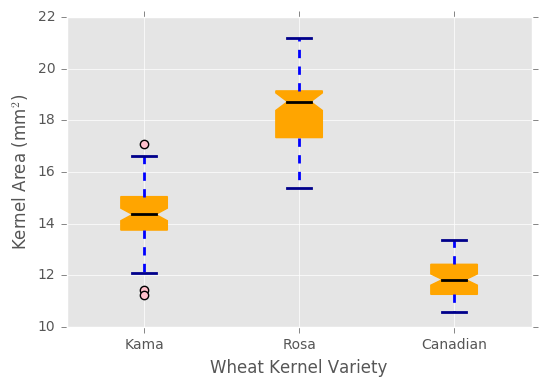

In [7]:
# Initialize figure and axes:
fig, ax = plt.subplots()

# Pick a color scheme for the boxplot with bright boxes, darker whiskers:
color = dict(boxes='Orange',
             whiskers='Blue',
             medians='Black',
             caps='DarkBlue')

# Emphasize the boxes with thicker lines:
whiskers = dict(linewidth=2, linestyle='--')
caps = dict(linewidth=2)
boxes = dict(linewidth=1, linestyle='-')
medians = dict(linewidth=2, linestyle='-')
fliers = dict(marker='o', markersize=6, markeredgewidth=1, markerfacecolor='Pink')

# Make the pivot table, and then make a boxplot.
# Add dictionaries to customize the desired properties:
# notch = True adds a little notch in the IQR box at the median
# patch_artist = True fills in the IQR box with the boxes color.
seed_df[['area','variety']]\
        .pivot(columns='variety', values='area')\
        .plot(kind="box",ax=ax, color=color,\
              whiskerprops=whiskers,\
              capprops=caps,\
              boxprops=boxes,\
              medianprops=medians,\
              flierprops=fliers,\
              notch=True,\
              patch_artist=True)

# Label the wheat varieties, and add x- and y-axis labels
x_ticks      = ax.set_xticks(np.arange(1,4))
x_ticklabels = ax.set_xticklabels(['Kama', 'Rosa', 'Canadian'])
xlabel       = ax.set_xlabel("Wheat Kernel Variety")
ylabel       = ax.set_ylabel("Kernel Area (mm$^2$)")

Let's look at another feature from `seed_df`. **Run** the cell below to generate a barplot of the `'compactness'` feature, a dimensionless number.

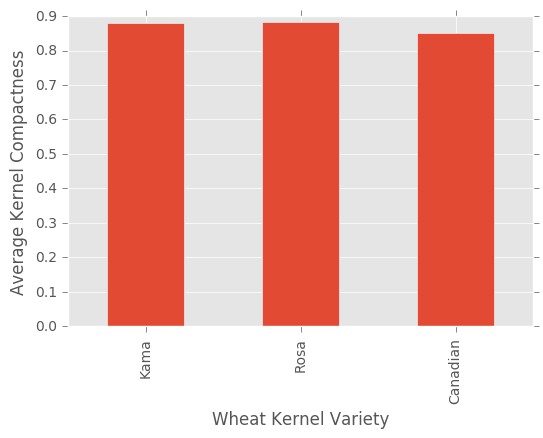

In [8]:
fig = seed_df.groupby("variety").mean()['compactness'].plot(kind="bar")
x_ticks = plt.xticks(range(3),['Kama', 'Rosa', 'Canadian'])
x_label = plt.xlabel("Wheat Kernel Variety")
y_label = plt.ylabel("Average Kernel Compactness")

**Run** the cell below to generate a boxplot of the `'compactness'` pivot table. Does the `'compactness'` feature seem like a good way to distinguish between the three varieties of wheat kernels? Why or why not?

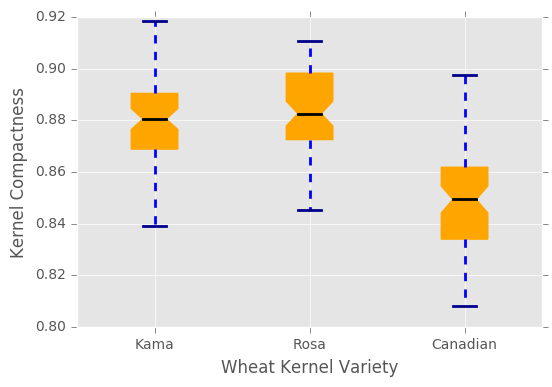

In [9]:
# Initialize figure and axes:
fig, ax = plt.subplots()

# Make the pivot table, and then make a boxplot.
seed_df[['compactness','variety']]\
        .pivot(columns='variety', values='compactness')\
        .plot(kind="box",ax=ax, color=color,\
              whiskerprops=whiskers,\
              capprops=caps,\
              boxprops=boxes,\
              medianprops=medians,\
              flierprops=fliers,\
              notch=True,\
              patch_artist=True)

# Label the wheat varieties, and add x- and y-axis labels
x_ticks = plt.xticks(np.arange(1,4),['Kama', 'Rosa', 'Canadian'])
x_label = plt.xlabel("Wheat Kernel Variety")
y_label = plt.ylabel("Kernel Compactness")

## Looking at multiple features: scatterplots!
The [`scatter` method](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) allows us to create a scatter plot: given two arrays `x` and `y` of the same length, the scatter plot will draw a point for every pair $(x_i,y_i)$ in the arrays. If we set the parameter `c` (for color) to the array `seed_df['variety']`, then each variety of wheat kernel will be plotted a different color given the color map `cmap`.

**Run** the cell below to generate a scatterplot of the wheat kernel `'area'` vs. `'asymmetry'`. Does it look like the three varieties of wheat kernels occupy distinct regions of the plane?

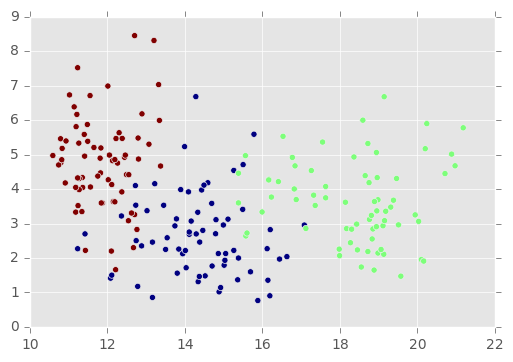

In [10]:
fig = plt.scatter(seed_df['area'],seed_df['asymmetry'],c=seed_df['variety'])

Again, my personal opinion is that the plot defaults don't look great here. The bright green points are hard to see, nothing is labeled, and I don't know which wheat kernels are which. For colorblind folks, the fact that the markers are all the same shape also makes interpretation difficult.

**Run** the cell below to generate a more customized scatterplot. Do you follow all the customization options?

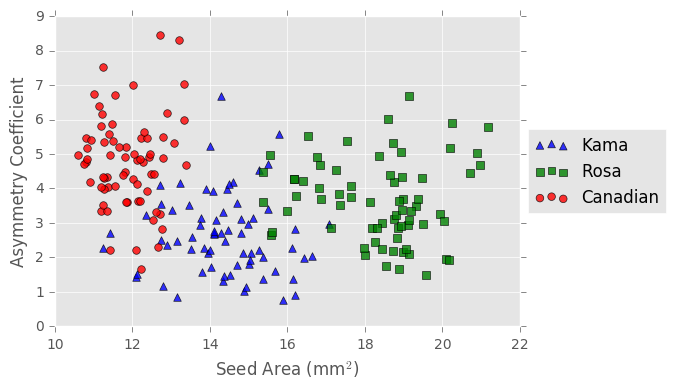

In [11]:
# Initialize figure and axes:
fig, ax = plt.subplots()

# Slice the original DataFrame using boolean indexing
df1 = seed_df[seed_df['variety']==1]
df2 = seed_df[seed_df['variety']==2]
df3 = seed_df[seed_df['variety']==3]

# Call scatter three times to plot each wheat kernel variety separately
# parameters: s         = marker size, in points^2
#             marker    = marker shape ('^' for triangles, 's' for squares, 'o' for circles, etc.)
#             edgecolor = marker edge color ('r' for red, 'g' for green, 'b' for blue, 'k' for black, etc.)
#             facecolor = marker face color ('r' for red, 'g' for green, 'b' for blue, 'k' for black, etc.)
#             alpha     = transparency (0 = fully transparent, 1 = opaque)
kama     = ax.scatter(x=df1['area'], y=df1['asymmetry'],\
                      s=30, marker = '^', edgecolor='k', facecolor='b', alpha=0.8)
rosa     = ax.scatter(x=df2['area'], y=df2['asymmetry'],\
                      s=30, marker = 's', edgecolor='k', facecolor='g', alpha=0.8)
canadian = ax.scatter(x=df3['area'], y=df3['asymmetry'],\
                      s=30, marker = 'o', edgecolor='k', facecolor='r', alpha=0.8)

# Label the x- and y- axes, put a legend outside of the plot, and set the x- and y- axis limits.
xlabel = ax.set_xlabel('Seed Area (mm$^2$)')
ylabel = ax.set_ylabel('Asymmetry Coefficient')
legend = ax.legend((kama,rosa,canadian),('Kama', 'Rosa', 'Canadian'),\
              loc='center left', bbox_to_anchor=(1.0, 0.5))
xlim = ax.set_xlim((10,22))
ylim = ax.set_ylim((0,9))

## Support Vector Classification & (non-wheat) Kernels

In this section, we are going to explore the [C-Support Vector Classification](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) class from `sklearn`. Mainly, we are going to look at the resulting decision boundaries that arise when using different [types of kernels](http://scikit-learn.org/stable/modules/svm.html#svm-kernels). The kernel function is a way to *quantify* how similar two inputs are to one another.

### Linear Kernel
Suppose we have two vectors in $\mathbb{R}^3$ (meaning the vectors have three real-valued entries):
$$\mathbf{a}=\left[\begin{array}{c}a_1\\a_2\\a_3\end{array}\right]\quad\textrm{and}\quad\mathbf{b}=\left[\begin{array}{c}b_1\\b_2\\b_3\end{array}\right]$$
The *linear kernel* is simply the [dot product](https://en.wikipedia.org/wiki/Dot_product), which we write as $\left\langle\textbf{a},\textbf{b}\right\rangle$ or $\textbf{a}\cdot\textbf{b}$. The dot product of vectors in $\mathbb{R}^3$ is equal to:
$$\left\langle\mathbf{a},\mathbf{b}\right\rangle=\mathbf{a}\cdot\mathbf{b}=a_1b_1+a_2b_2+a_3b_3$$

This definition can be extended to vectors of any length. For two vectors in $\mathbb{R}^n$, the dot product is equal to:
$$\left\langle\mathbf{a},\mathbf{b}\right\rangle=\mathbf{a}\cdot\mathbf{b}=a_1b_1+\cdots+a_nb_n$$

The *norm* or *length* $\left\Vert\mathbf{a}\right\Vert$ of a vector $\mathbf{a}$ is given by the positive square root of the dot product of $\mathbf{a}$ with itself:
$$\left\Vert\mathbf{a}\right\Vert=\sqrt{\mathbf{a}\cdot\mathbf{a}}$$
Given any two vectors $\mathbf{a}$ and $\mathbf{b}$, the *maximum* value that the dot product can take is the product of the two vector norms, $\left\Vert\mathbf{a}\right\Vert\left\Vert\mathbf{b}\right\Vert$, when the vectors are *parallel*, or point in the same direction. The *minimum* value that the dot product can take is the negative product of the two vector norms, $-\left\Vert\mathbf{a}\right\Vert\left\Vert\mathbf{b}\right\Vert$, when the two vectors are *antiparallel*, or point in opposite directions.

The three other kernels we will discuss are derived from the linear kernel.

### Polynomial Kernel
The *polynomial kernel* is useful when the data points are not linearly separable. It uses the linear kernel in its definition:
$$K(\mathbf{a},\mathbf{b})=\left(\gamma\left\langle\mathbf{a},\mathbf{b}\right\rangle+r\right)^d$$
We've introduced a few parameters in the polynomial kernel:
  - $d$ is the *degree* of the polynomial kernel. The larger $d$ is, the more nonlinear the kernel will be.
  - $\gamma$ (gamma) is the *kernel coefficient* -- if gamma is larger, the "distance" between any two points as defined by the kernel is magnified. If gamma is smaller, the "distance" between any two points as defined by the kernel is diminished. Basically what this is saying is that the larger gamma is, the less that faraway points will influence the classification of a given point.
  - $r$ is the *independent term*, adding an additional offset to the kernel.

### Sigmoid Kernel
The two kernels mentioned above, linear and polynomial, are unbounded. However, the *sigmoid kernel* is bounded between -1 and 1:
$$K(\mathbf{a},\mathbf{b})=\tanh\left(\gamma\left\langle\mathbf{a},\mathbf{b}\right\rangle+r\right)$$
Here, $\tanh(x)$ is the [hyperbolic tangent function](http://mathworld.wolfram.com/HyperbolicTangent.html), which approaches -1 when the argument $x$ is large and negative, and approaches +1 when the argument $x$ is large and positive . The two parameters, $\gamma$ and $r$, have a similar interpretation here as in the polynomial kerenel.

### Radial Basis Function (RBF) Kernel
The [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel), or *RBF kernel*, adds a Gaussian "bump" about each data point:
$$K(\mathbf{a},\mathbf{b})=\exp\left(-\gamma\left\Vert\mathbf{a}-\mathbf{b}\right\Vert^2\right)$$
Here, there is a restriction that the *kernel coefficient* $\gamma$ is positive. Again, a larger $\gamma$ will accentuate the distance between faraway points, and lessen their influence on classification.

## Soft vs. Hard Margins
There is an additional parameter in the `SVC` class that we've yet to talk about. The `C` parameter is a measure of how "hard" to make the margins. Consider this example that is linearly separable with a single outlier:
![hard margin linearly separable](http://yaroslavvb.com/upload/save/so-svm.png)
[Image credit - Yaroslav Bulatov on StackOverflow](http://stackoverflow.com/questions/4629505/svm-hard-or-soft-margins)

The picture depicts the decision boundary resulting from a hard-margin SVM. There is a *huge* penalty to misclassifying the one red outlier near the blue population. So the decision boundary in a hard-margin SVM tries to perfectly classify data first and foremost. In this example, the `C` parameter would be very large. Essentially, outliers dictate decision boundaries in hard-margin SVMs. However, the **margin**, or the distance from the points to the decision boundary, is not great for almost all the blue points. A soft-margin SVM (with a smaller value of the `C` parameter) is more willing to misclassify a point in order to improve the margins for the other points.

For further reading on `C` and soft- vs. hard-margin SVM, check out [this Quora post](https://www.quora.com/What-are-C-and-gamma-with-regards-to-a-support-vector-machine) and [this StackOverflow post](http://stackoverflow.com/questions/4629505/svm-hard-or-soft-margins)!

## Let's make some decision boundaries!

Now that we've introduced the ideas of kernels and margin for Support Vector Machines, let's introduce a method that can plot decision boundaries for a given classifier!

**Read** the cell below to get an idea of how the `PlotDecisionBoundary` method works. As you read through the code, you may want to check the documentation for a few methods and classes used here if you are unfamiliar with them:
  - From `sklearn.svm`:
      - [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
  - From `numpy`:
      - [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html)
      - [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html)
      - [reshape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html)
      - [ravel](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html)
      - [c\_](https://docs.scipy.org/doc/numpy/reference/generated/numpy.c_.html)
  - From `matplotlib`:
      - [subplots](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.subplots)
      - [contourf](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.contourf)
      
Once you feel like you understand what's going on in the method, run the cell to make `PlotDecisionBoundary()` available to use.

In [12]:
from sklearn.svm import SVC

def PlotDecisionBoundary(clf = SVC(kernel='linear', C = 1.0),\
                         title = "SVM, Linear Kernel, C = 1.0",\
                         x_feature = 'area',\
                         y_feature = 'asymmetry',\
                         x_label = 'Seed Area (mm$^2$)',\
                         y_label = 'Asymmetry Coefficient'):
    
    '''
    Plots decision boundaries for a classifier trained on two features from seed_df
    @param clf:       a classifier object from sklearn
    @param title:     a string to use as the title of the plot
    @param x_feature: a string, the name of the feature from seed_df to plot along the x-axis
    @param y_feature: a string, the name of the feature from seed_df to plot along the y-axis
    @param x_label:   a string to use as the x-axis label of the plot
    @param y_label:   a string to use as the y-axis label of the plot
    '''
    
    # Initialize figure and axes:
    fig, ax = plt.subplots()

    # This demo plots a decision boundary based on two features,
    # so pull the two features from seed_df
    X = seed_df[[x_feature,y_feature]]
    
    # We want to see the decision boundary between the three classes
    # of wheat seeds (Kama, Rosa, and Canadian).
    y = seed_df['variety']
    
    # Fit the classifier using the two target features
    clf.fit(X,y)
        
    # Determine the min & max values of x_feature, compute the range,
    # and pad the minimum and maximum x values by 5% of the range
    x_min, x_max = X[x_feature].min(), X[x_feature].max()
    x_range = x_max - x_min
    x_min -= x_range * 0.05
    x_max += x_range * 0.05
    
    # Determine the min & max values of y_feature, compute the range,
    # and pad the minimum and maximum y values by 5% of the range
    y_min, y_max = X[y_feature].min(), X[y_feature].max()
    y_range = y_max - y_min
    y_min -= y_range * 0.05
    y_max += y_range * 0.05
    
    # Return coordinate matrices xx and yy from arrays
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num = 500),\
                         np.linspace(y_min, y_max, num = 500))
    
    # Use the classifier clf to make a prediction for each point
    # in the coordinate matrices, then reshape for plotting.
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot semitransparent filled contours for the decision boundaries
    ax.contourf(xx, yy, Z, levels=[0.5,1.5,2.5,3.5],\
                 colors=('b', 'g', 'r'),alpha=0.3)

    # Scatterplot all of the points that trained the classifier
    # matching the colors for each region.
    ka = ax.scatter(df1[x_feature], df1[y_feature],\
                    s=30, marker = '^', edgecolor='k', facecolor='b', alpha=0.8)
    ro = ax.scatter(df2[x_feature], df2[y_feature],\
                    s=30, marker = 's', edgecolor='k', facecolor='g', alpha=0.8)
    ca = ax.scatter(df3[x_feature], df3[y_feature],\
                    s=30, marker = 'o', edgecolor='k', facecolor='r', alpha=0.8)
    
    # Set the title and axes labels
    title   = ax.set_title(title)
    x_label = ax.set_xlabel(x_label)
    y_label = ax.set_ylabel(y_label)
    
    # Put a legend to the right of the current axis
    ax.legend((ka,ro,ca),('Kama', 'Rosa', 'Canadian'),\
              loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    # Set the x- and y-axis limits using the padded minimum and maximum values
    xlim = ax.set_xlim((x_min,x_max))
    ylim = ax.set_ylim((y_min,y_max))
    
print("PlotDecisionBoundary() is ready to use!")
    

PlotDecisionBoundary() is ready to use!


**Run** the cell below to see `PlotDecisionBoundary()` in action!

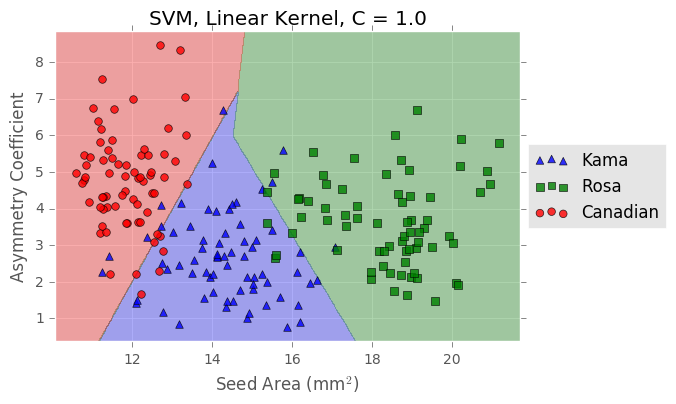

In [13]:
PlotDecisionBoundary()

We see that our `PlotDecisionBoundary` method defaults to a `SVM` with a `'linear'` kernel, and the softness parameter `C` is equal to 1.0. With the linear kernel, the decision boundaries between the wheat seed varieties are straight lines! There appears to be one blue Kama outlier with an asymmetry coefficient close to 7 that is pushing the Kama/Canadian decision boundary kind of steep. Let's see what happens when we reduce `C`...

**Run** the cell below to plot the decision boundaries for an even softer soft-margin SVM (`C` = 0.0001):

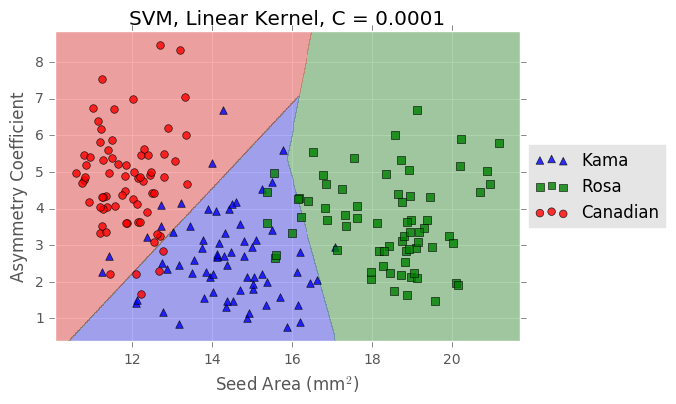

In [14]:
PlotDecisionBoundary(clf=SVC(kernel="linear",C=0.0001), title = "SVM, Linear Kernel, C = 0.0001")

We've reduced the influence of the blue Kama outlier by using a soft-margin SVM, as expected! What if we have a hard-margin SVM with large penalties for misclassification?

**Run** the cell below to plot the decision boundaries for a hard-margin SVM (`C` = 1000.0)

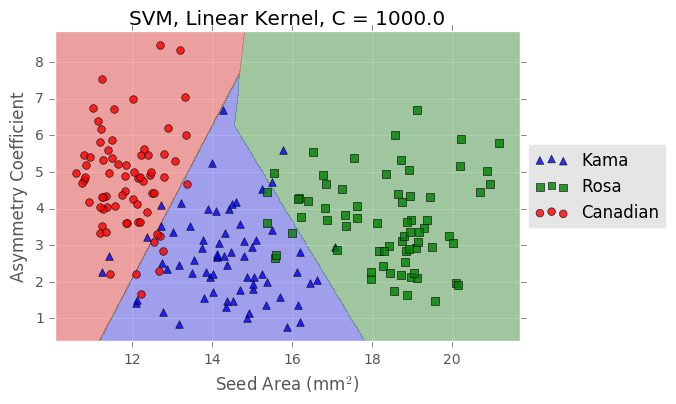

In [15]:
PlotDecisionBoundary(clf=SVC(kernel="linear",C=1000.0), title = "SVM, Linear Kernel, C = 1000.0")

With a large value of `C`, the classifier tries first and foremost to get the correct variety, then maximize the margins second. Here, we see a stronger influence of the outliers in shaping the decision boundaries. However, the data is not linearly separable -- there's no straight line that can perfectly classify all points. With a linear kernel and two features, we're only guaranteed perfect classification for up to three data points. Perfectly classifying a data set is called [shattering](https://en.wikipedia.org/wiki/VC_dimension).

With other types of classifiers or kernels, we can shatter larger data sets (at the risk of overfitting). Let's look at some of those kernels!

**Run** the cell below to plot the decision boundaries for a `poly` kernel of degree 2:

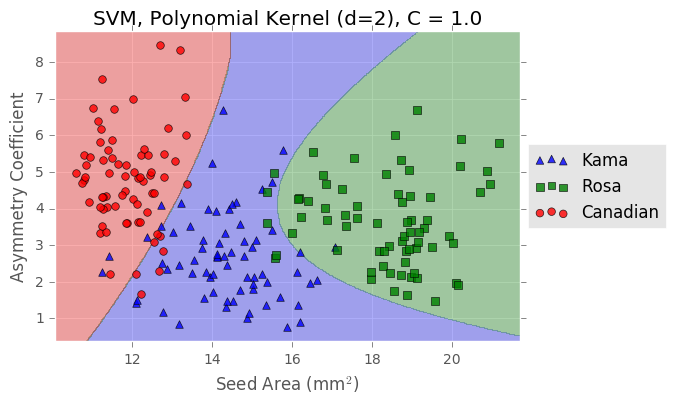

In [16]:
PlotDecisionBoundary(clf=SVC(kernel="poly",degree=2, C=1.0), title = "SVM, Polynomial Kernel (d=2), C = 1.0")

With a degree-2 polynomial kernel, any resulting decision boundary between two varieties is a *parabola*. Like we did for the linear kernel, we can play around with the penaly term `C`.

**Run** the cell below to plot the decision boundaries for a hard-margin SVM (C = 1000.0) with a degree-2 polynomial kernel.

In [ ]:
PlotDecisionBoundary(clf=SVC(kernel="poly",degree=2, C=1000.0), title = "SVM, Polynomial Kernel (d=2), C = 1000.0")

The decision boundaries work harder to correctly classify all points, but there are still some points that are misclassified. What if we further increase the degree of the polynomial?

**Run** the cell below to plot the decision boundaries for a hard-margin SVM (C = 1000.0) with a degree-5 polynomial (warning: this will take a bit longer than the previous examples)

KeyboardInterrupt: 

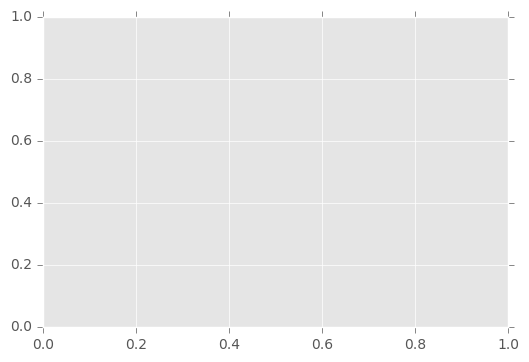

In [18]:
PlotDecisionBoundary(clf=SVC(kernel="poly",degree=5, C=1000.0), title = "SVM, Polynomial Kernel (d=5), C = 1000.0")

The decision boundaries look more and more nonlinear with higher polynomial dimensions!

Let's take a look at `rbf` kernels. **Run** the cell below to see how the `rbf` kernel creates decision boundaries.

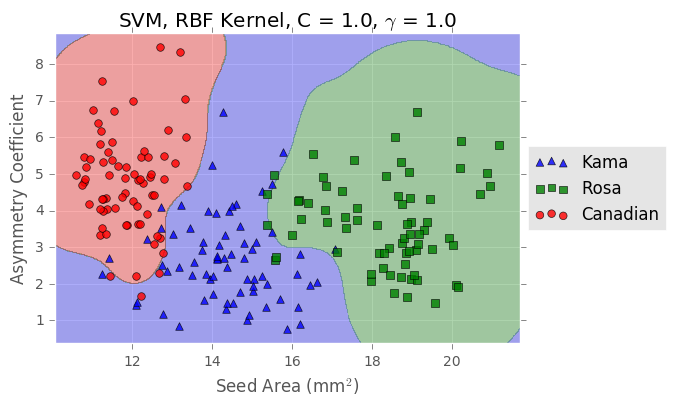

In [19]:
PlotDecisionBoundary(clf=SVC(kernel="rbf", C=1.0, gamma = 1.0), title = "SVM, RBF Kernel, C = 1.0, $\gamma$ = 1.0")

We get a highly nonlinear decision boundary using the `rbf` kernel. Let's try increasing the influence of faraway points by decreasing $\gamma$. **Run** the cell below to see the resulting decision boundary when faraway points influence the classification more strongly.

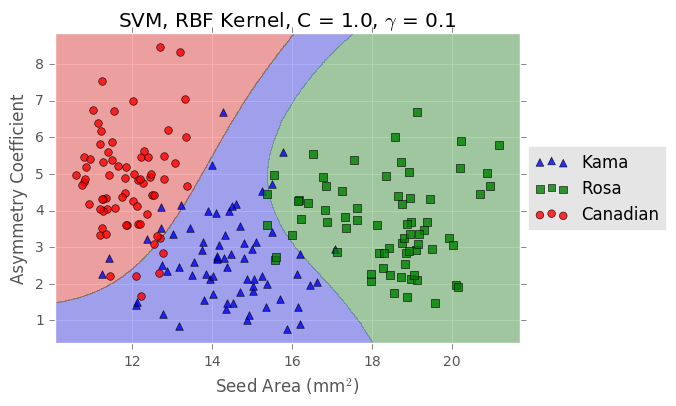

In [20]:
PlotDecisionBoundary(clf=SVC(kernel="rbf", C=1.0, gamma = 0.1), title = "SVM, RBF Kernel, C = 1.0, $\gamma$ = 0.1")

When faraway points are influencing the classification more strongly (with a smaller $\gamma$), the decision boundaries are smoothed out and the model appears to have lower variance. What if we increase $\gamma$, so that only nearby points influence classification?

**Run** the cell below to see the resulting decision boundary when only nearby points influence classification.

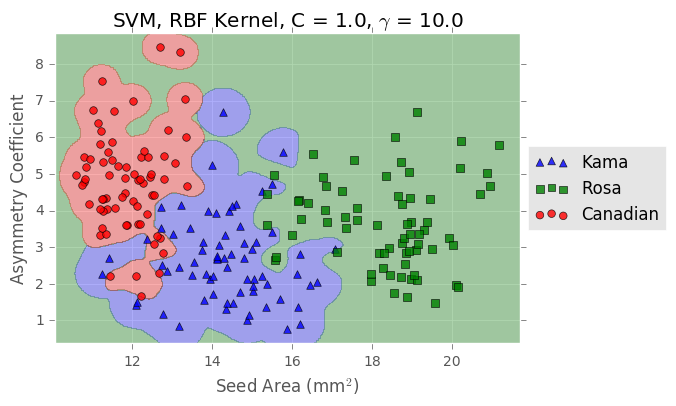

In [ ]:
PlotDecisionBoundary(clf=SVC(kernel="rbf", C=1.0, gamma = 10.0), title = "SVM, RBF Kernel, C = 1.0, $\gamma$ = 10.0")

Wow, these decision boundaries are a little ridiculous! This is definitely an example of overfitting or a high-variance model -- be careful of this problem when using the `rbf` kernel with a large value of $\gamma$.

We can also fall into the overfitting trap by setting the `C` parameter too high with the `rbf` kernel. **Run** the cell below to plot the decision boundaries for a hard-margin SVM using the `rbf` kernel:

In [ ]:
PlotDecisionBoundary(clf=SVC(kernel="rbf", C=1000.0, gamma = 1.0),\
                     title = "SVM, RBF Kernel, C = 1000.0, $\gamma$ = 1.0")

So to summarize, by setting `C` or `gamma` to too large of a value, you can overfit the training data and generate decision boundaries that appear somewhat nonsensical. Although the above two plots classify the training data points successfully, the decision boundaries suffer from high variance.

One last note, you can play with `PlotDecisionBoundary` using other features from `seed_df`. For example, **Run** the cell below to use the `'length_kernel'` and `'compactness'` features. Note, I made sure to update the parameters `x_label` and `y_label` as well as `x_feature` and `y_feature` so that the resulting decision boundary plot is properly labeled.

In [ ]:
PlotDecisionBoundary(clf=SVC(kernel="linear", C=1000.0), title = "SVM, Linear Kernel, C = 1000.0",\
                     x_feature = "length_kernel", y_feature = "compactness",\
                     x_label = "Kernel Length ($mm$)", y_label = "Compactness")

## Now it's your turn!

Take some time to explore the different kernels -- play with the parameters in `SVC`, and build some intuition as to how the decision boundaries change with `kernel`, `C`, `gamma`, `degree`, etc. Can you find an interesting combination of features and parameters for a unique resulting decision boundary?

## A `GridSearchCV` example for SVMs

There are a few different kernels we could select from, and with each of those kernels, there are additional parameters we could play with:
  - Will a hard-margin (large `C`) or soft-margin (small `C`) SVM work best?
  - Should only nearby points (large `gamma`) or nearby and faraway points (small `gamma`) shape the prediction?
  - How complex should a polynomial kernel be (`degree`)?

With [the method `GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), we can brute-force test a bunch of combinations of kernels and parameters (called hyperparamters) and use cross-validation to assess how well each of the hyperparameter combinations might generalize to out-of-sample data.

**Read** through the cell below to get an overview of how to conduct a hyperparameter grid search using `GridSearchCV`, then **run** the cell below to see the results of `GridSearchCV`. What is the optimal model? You may need to edit the import statements if you are using an earlier version of `sklearn` than 0.18.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

# Step 1: Separate features (X) and labels (y)
X = seed_df.drop('variety', axis=1)
y = seed_df['variety']

# Step 2: Create an estimator object
svr = SVC()

# Step 3: Build a parameter dictionary (or list of parameter dictionaries)
#         GridSearchCV will perform cross-validation on all possible combinations
#         of parameters in each dictionary in the list.
parameters = [{'kernel':['rbf'],\
               'gamma' :[0.01, 0.1, 1.0, 10.0, 100.0],\
               'C'     :[0.01, 0.1, 1.0, 10.0, 100.0]},\
              {'kernel':['linear'],\
               'C'     :[0.01, 1.0, 100.0]}]

# Step 4: Select a cross-validation scheme
# In this example, I will use StratifiedShuffleSplit
#   StratifiedShuffleSplit ensures that the training and testing sets have 
#   proportionate representation of each label.
#   For example, there are 210 instances, 70 of each wheat seed variety.
#   With a test size of 0.2, 20% of the instances (42) will be in the test set
#   There will be equal representation (14 instances) of each wheat seed variety
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)

# Step 5: Make a scorer
# How will you assess how well each combination of parameters performs?
scorer = make_scorer(score_func=accuracy_score)

# Step 6: Create the GridSearchCV object and fit it
# This performs the brute-force cross validation on all parameter combinations
clf = GridSearchCV(estimator=svr, param_grid=parameters, cv = sss, scoring = scorer)
clf.fit(X,y)

# Step 7: Present the results
# Which combination of parameters worked best?
print("Best parameters set found on development set:")
print(" ")
print(clf.best_params_)
print(" ")
print("Grid scores on development set:")
print(" ")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print(" ")
